# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. 

Необходимо построить модель для определения стоимости. 

***Заказчику важны***:

- качество предсказания;
- скорость предсказания;
- время обучения.

Проект будет выполнятся согласно ***плану*** ниже:

1. Подготовка данных:

 - Изучение исходных данных и выявление аномалий;
 - Предобработка данных;
 - Подготовка признаков к работе с моделями;
 
 
2. Подбор наилучших моделей;


3. Анализ времени работы и эффективности отобранных моделей;


4. Формирование итогового вывода.

## Подготовка данных

In [1]:
! pip install scikit_learn --upgrade
# ! pip install xgboost --upgrade

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit_learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0)


Импортируем необходимые для работы библиотеки:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import catboost as cb
import warnings

Загрузим исходные данные:

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

### Изучение данных

Выведем на экран первые 5 строк таблицы и общую информацию о данных:

In [4]:
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


В датасете всего 354 369 строк. В столбцах ***VehicleType***, ***Gearbox***, ***Model***, ***FuelType***, ***NotRepaired*** имеются пропуски данных.

Выведем на экран доли пропусков данных в каждом из столбцов датасета:

In [5]:
(data.isna().mean() * 100).round(2).to_frame().style.background_gradient(cmap='coolwarm')

,0
DateCrawled,0
Price,0
VehicleType,10.58
RegistrationYear,0
Gearbox,5.6
Power,0
Model,5.56
Kilometer,0
RegistrationMonth,0
FuelType,9.28


Столбцы содержат от ***5,56*** до ***20,08%*** пропусков данных.

Проверим датасет на наличие грубых дубликатов:

In [6]:
data.duplicated().sum()

4

Обнаружены 4 грубых дубликата.

Проверим категориальные признаки на наличие скрытых дубликатов.

In [7]:
def show_hiden_duplicates(column):
    print(column)
    print()
    print(sorted(list(data[data[column].isna() == False][column].unique())))
    print()

In [8]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']:
    show_hiden_duplicates(column)

VehicleType

['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

Gearbox

['auto', 'manual']

Model

['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'e

В столбце ***Model*** модели ***range_rover*** и ***rangerover*** представляют одну и ту же модель автомобиля;

В столбце ***FuelType*** типы топлива ***gasoline*** и ***petroleum***, представляют один и тот же тип топлива ***бензин***.

Выведем описательную статистику исходных данных и посмотрим, есть ли аномальные значения в максимальных и минимальных значениях численных признаков:

In [9]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


###### Вывод

Всего в таблице 16 столбцов со следующими типами данных: int64, object.

Каждый объект в наборе данных — это информация об одном объявлении о выставленном на продажу автомобиле. Известно:

 - ***DateCrawled*** — дата скачивания анкеты из базы
 - ***VehicleType*** — тип автомобильного кузова
 - ***RegistrationYear*** — год регистрации автомобиля
 - ***Gearbox*** — тип коробки передач
 - ***Power*** — мощность (л. с.)
 - ***Model*** — модель автомобиля
 - ***Kilometer*** — пробег (км)
 - ***RegistrationMonth*** — месяц регистрации автомобиля
 - ***FuelType*** — тип топлива
 - ***Brand*** — марка автомобиля
 - ***NotRepaired*** — была машина в ремонте или нет
 - ***DateCreated*** — дата создания анкеты
 - ***NumberOfPictures*** — количество фотографий автомобиля
 - ***PostalCode*** — почтовый индекс владельца анкеты (пользователя)
 - ***LastSeen*** — дата последней активности пользователя
 - ***Price*** — цена (евро)

В датасете обнаружены пропуски данных в следующих столбцах:

 - ***VehicleType***, 10.58% пропусков;
 - ***Gearbox***, 5.6% пропусков;
 - ***Model***, 5.56% пропусков;
 - ***FuelType***, 9.28% пропусков;
 - ***NotRepaired***, 20.08% пропусков.

Тип данных всех перечисленных столбцов - ***object***. Пропуски могут быть связаны с ошибками при формировании базы данных анкет или с тем, что авторы объявлений указывали неполную информацию при заполнении анкет на продажу автомобилей. Для дальнейшей обработки пропуски рекомендуется заменить на неопределенные категории.

Так же в датасете обнаружены 4 грубых дубликата и скрытые дубликаты:

 - В столбце ***Model*** модели ***range_rover*** и ***rangerover***, представляют одну модель, но записаны по-разному;
 - В столбце ***FuelType*** типы топлива ***gasoline*** и ***petroleum***, являются разными вариантами обозначения типа топлива ***бензин***.
 
Рекомендуется устранение скрытых дубликатов путем переименования дублирующихся категорий, а также удаление грубых дубликатов.

Из описательной статистики выделяются следующие аномалии:

 - В ***Price*** объекты с нулевой стоимостью;
 - В ***RegistrationYear*** объекты с годами регистрации автомобиля 1000 и 9999;
 - В ***Power*** объекты с мощностью 0 и 20000 л.с.;
 - В ***RegistrationMonth*** объекты с нулевым месяцем регистрации;
 - В ***NumberOfPictures*** отсутствие каких-либо значений, кроме нулевых.
 
 
Данные, содержащиеся в столбцах ***DateCrawled***, ***DateCreated***, ***LastSeen*** не являются ни характеристиками автомобилей, ни характеристиками, связанными с областями продажи автомобилей, и, соответственно, с минимальной вероятностью влияют на цену автомобилей. Рекомендуется удаление данных столбцов из датасета для ускорения работы и улучшения качества моделей.

### Исследование признаков с аномальными значениями

Далее подробнее рассмотрим признаки с выявленными аномалиями.

 Напишем функцию для изучения распределения значений признаков:

In [10]:
def explore_distribution(data, column, title, xlabel, ylabel, bins, xlim):

    #Create Fig and gridspec
    fig = plt.figure(figsize=(16, 9), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

    # Define the axes
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

    # Scatterplot on main ax
    ax_main.hist(data[column], bins = bins)

    # Add a graph in each part
    sns.boxplot(data[column], ax=ax_bottom)

    # Decorations ------------------
    # Remove x axis name for the boxplot
    ax_bottom.set(xlabel='')

    # Main Title, Xlabel and YLabel
    ax_main.set(title=title, xlabel=xlabel, ylabel=ylabel)

    # Set font size of different components
    ax_main.title.set_fontsize(14)
    for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
        item.set_fontsize(14)
        
    ax_main.set_xlim(xlim)
    ax_bottom.set_xlim(xlim)
    
    plt.show()

Изучим признак ***Price***:

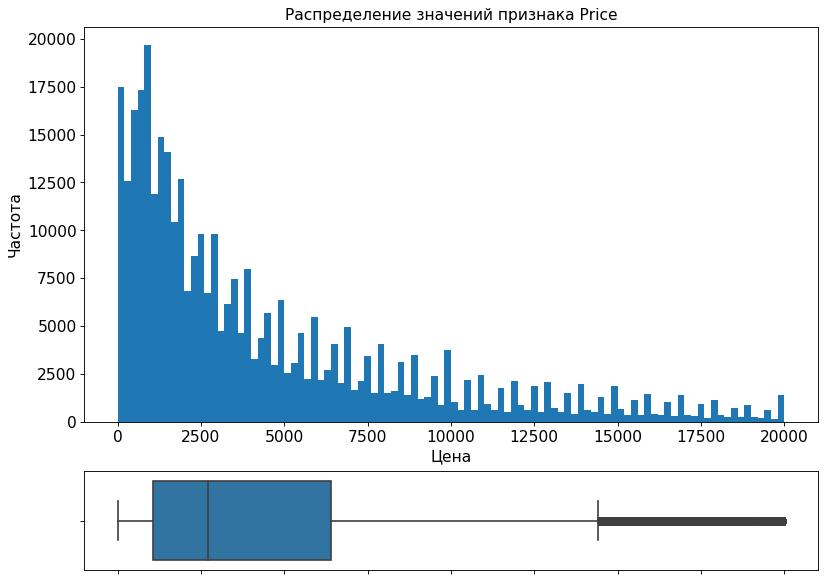

In [11]:
explore_distribution(
    data,
    'Price',
    'Распределение значений признака Price',
    'Цена',
    'Частота',
    100,
    None
)

Построенная гистограмма демонстрирует нам Пуассоновское распределение значений. При этом из гистограммы и диаграммы размаха видно, что обнаруженные нами ранее нулевые значения цен не являются статистическими выбросами. Кроме того, мы видим, что цены на автомобили ниже 1000 евро в датасете встречаются достаточно часто. Рассмотрим подробнее диапазон гистограммы с ценами от 0 до 500 евро:

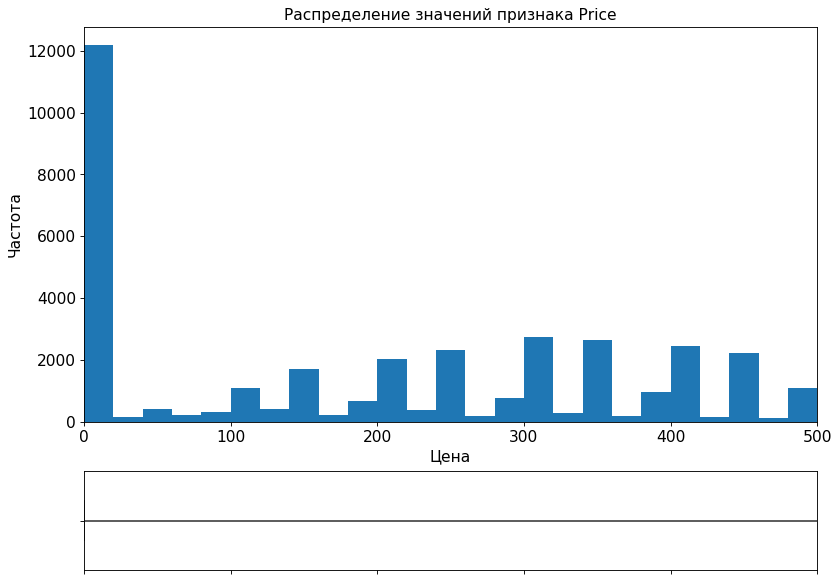

In [12]:
explore_distribution(
    data,
    'Price',
    'Распределение значений признака Price',
    'Цена',
    'Частота',
    1000,
    [0,500]
)

Среди низких цен на автомобили наиболее выделяются цены от 0 до 25 евро, встречающиеся наиболее часто. 
Возможно, столь низкие цены связаны с крайне плохим состоянием автомобилей. Проверим данное предположение, взяв срез датасета по ценам не более 25 евро:

In [13]:
data[data['Price'] <= 25].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05


Из среза видно, что экстемально низкие цены встречаются и у старых, и у относительно свежих автомобилей как с небольшим, так и с большим пробегом, что не подтверждает наше предположение: низкие цены не зависят от состояния автомобилей и, вероятнее всего, связаны с человеческим фактором при внесении данных об автомобилях в анкеты или с ошибками при формировании базы данных.

Изучим признак ***RegistrationYear***:

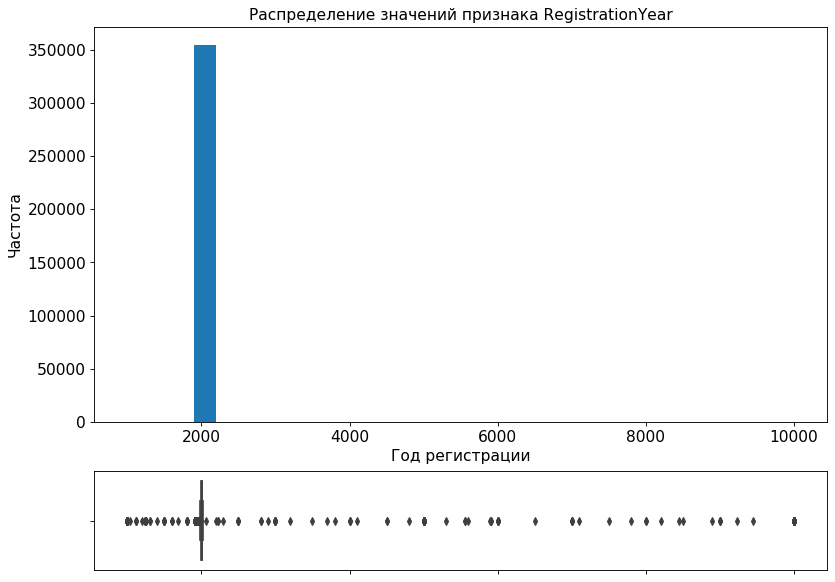

In [14]:
explore_distribution(
    data,
    'RegistrationYear',
    'Распределение значений признака RegistrationYear',
    'Год регистрации',
    'Частота',
    30,
    None
)

Среди значений годов регистрации автомобилей встречается множество аномальных значений. Построим гистограмму, ограничившись периодом с начала 20 века до текущего времени:

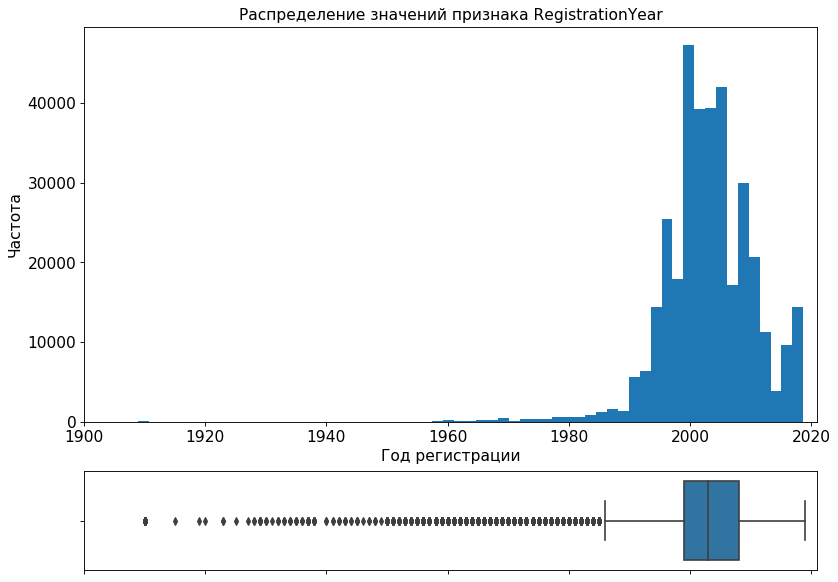

In [15]:
explore_distribution(
    data,
    'RegistrationYear',
    'Распределение значений признака RegistrationYear',
    'Год регистрации',
    'Частота',
    5000,
    [1900,2021]
)

На данном масштабе хорошо видно распределение значений, близкое к нормальному, а также статистически значимый диапазон. Выбросами считаются годы меньше 1985. Но фактически, рынок подержаных автомобилей может предлагать и более старые модели. Поэтому выбросами будем считать годы регистрации автомобилей раньше 1950.

Рассчитаем долю аномалий, рекомендованных к удалению из датасета:

In [16]:
print((data[data['RegistrationYear'] < 1950]['RegistrationYear'].count()/len(data)*100).round(2), '%')

0.07 %


При удалении выбросов будет потеряно незначительное количество объектов.

Изучим признак ***Power***:

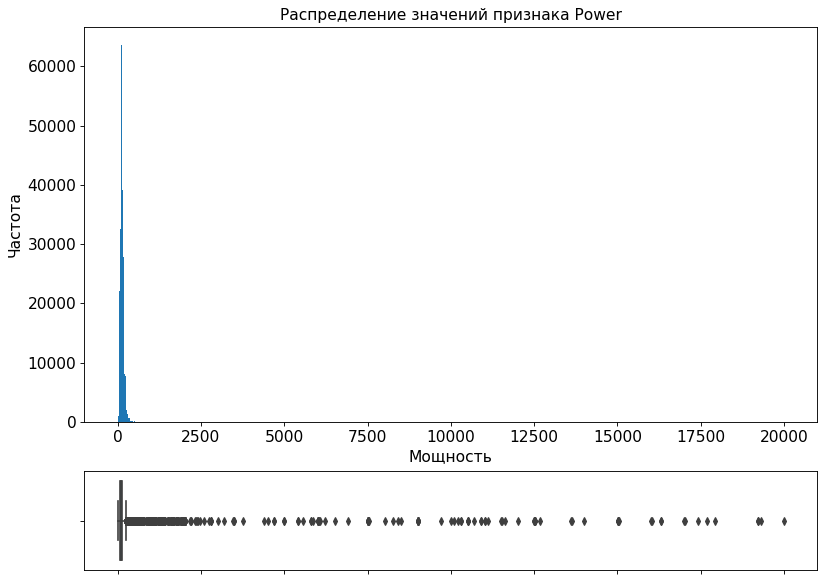

In [17]:
explore_distribution(data, 'Power','Распределение значений признака Power', 'Мощность', 'Частота',1000, None)

Среди значений мощности двигателей автомобилей также встречается множество аномальных значений. Построим гистограмму, ограничившись диапазоном от 0 до 1500 л.с:

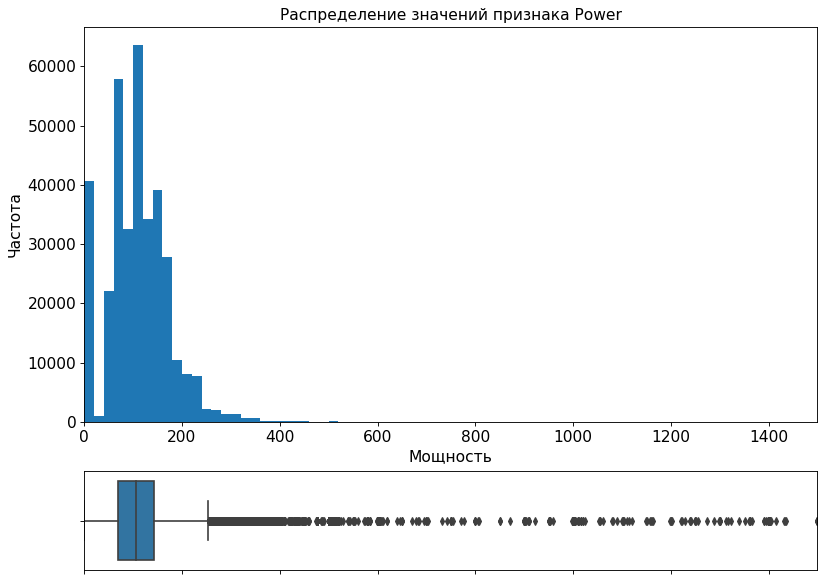

In [18]:
explore_distribution(data,'Power','Распределение значений признака Power', 'Мощность', 'Частота',1000, [0,1500])

Из гистограммы видно, что в рассматриваемых данных статистически значимым диапазоном мощности является диапазон от 0 до 250 л.с. 

Нулевые значения нелогичны, несмотря на то, что входят в статистически значимый диапазон. Но так как они встречаются в данном признаке очень часто, избавление от них приведет к потере большого количества данных.

Среди статистических выбросов более или менее высокая плотность значений сохраняется до 600 л.с, остальные значения крайне редки.

Фактически встречаются автомобили с мощностью двигателей и больше 250 л.с. Как правило, это внедорожники и мощные кроссоверы. Отдельные экземпляры автомобилей обладают и мощностью свыше 1000 л.с., но, как правило, это спорткары, в том числе и ограниченных серий, поэтому маловероятно их встретить среди выставленных на продажу подержаных автомобилей.

Рассмотрим срез датасета по автомобилям с мощностью двигателя более 600 л.с. 

In [19]:
data[data['Power'] >= 600].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21 00:00:00,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36


Из среза видно, что высокая мощность в анкетах указывается для довольно обыденных марок и моделей автомобилей. Вероятнее всего, что причинами аномалий в этом признаке являются те же, что и в рассмотренных ранее признаках: ошибки пользователей при внесении данных в анкеты либо ошибки при формировании базы данных.

Значимым для дальнейшей работы будем считать диапазон мощностей до 600 л.с.

Изучим признак ***RegistrationMonth***:

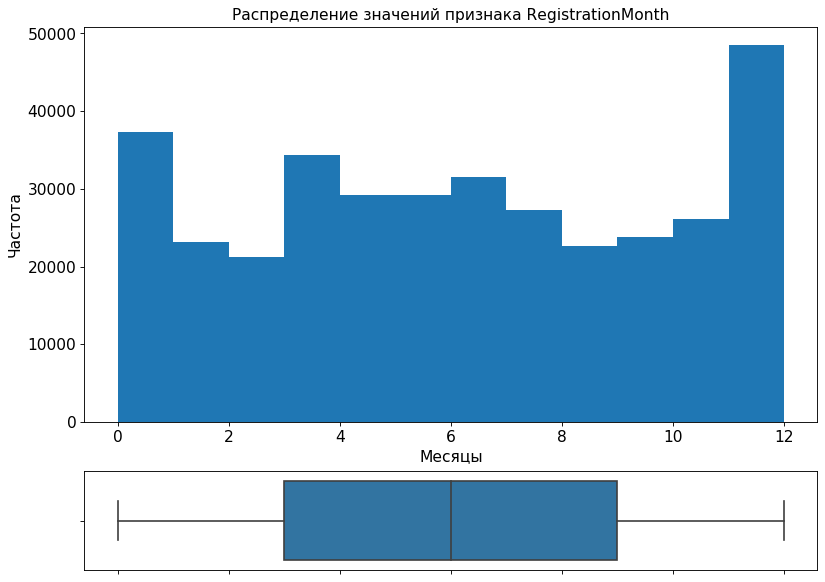

In [20]:
explore_distribution(
    data,
    'RegistrationMonth',
    'Распределение значений признака RegistrationMonth',
    'Месяцы',
    'Частота',
    12,
    None
)

Статистических выбросов в рассматриваемом признаке нет, но заметен аномальный, нулевой, месяц, встречающийся очень часто. Посмотрим, какую долю от общего количества значений признака занимает аномалия:

In [21]:
print((data[data['RegistrationMonth'] == 0]['RegistrationMonth'].count()/len(data)*100).round(2), '%')

10.54 %


Удаление аномальных объектов по данному признаку не рекомендуется, так как при этом будет потеряно более 10% данных из датасета.

###### Вывод

На данном этапе были подробно рассмотрены признаки с аномальными значениями.

В признаке ***Price*** обнаружены нулевые и крайне низкие цены, не являющиеся статистическими выбросами, но правдивость которых маловероятна. Если бы была возможность отработать с заказчиком наиболее адекватный диапазон цен, которые должны использоваться в качестве целевого признака, датасет был бы подготовлен соответствующим образом, но в рамках учебного проекта, за неимением возможности проверить природу аномалий, признак будет оставлен без обработки.

В признаке ***RegistrationYear*** обнаружены аномальные годы регистрации автомобилей: раньше 1900 года и позже 2021 года. Значимым для дальнейшей работы принимаем период регистрации с 1950 по текущее время.

В признаке ***Power*** обнаружены аномальные мощности в виде нулей и тысячей л.с.. Нулевые значения будут оставлены без обработки, т.к. их доля достаточно высока, и их удаление приведет к большой потере данных. Вариант логичной замены, например, с помощью медиан, рассчитанных по нескольким признакам, не рассматривается, так как большое количество пропущенных значений в категориальных признаках будут заполнены неопределенными категориями, и замененные значения с помощью вычисленных медиан могут еще сильнее искажать реальную картину. Рабочим будем считать диапазон от 0 до 600 л.с., так как двигателями с большей мощностью обладают только специализированные автомобили: спорткары, маслкары и кастомизированные автомобили, которые не выставляются на продажу в ценовом диапазоне целевого признака.

В признаке ***RegistrationMonth*** обнаружен нулевой месяц. Логичная замена нулевых значений в данном случае невозможна, но и удалять объекты с нулевым месяцем регистрации не будем, т.к. доля аномалий составляет 10.54%, и их удаление приведет к потере большого количества данных.

### Предобработка данных

Заполним пропуски в категориальных признаках на неопределенную категорию ***unknown***:

In [22]:
data = data.fillna('unknown')

Проверим заполнение пропусков:

In [23]:
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          354369 non-null object
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null object
Power                354369 non-null int64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Пропуски успешно заполнены.

Избавимся от скрытых дубликатов.

В столбце ***Model*** переименуем категорию ***rangerover*** в ***range_rover***:

In [24]:
def rename_rangerover(row):
    if row == 'rangerover':
        return 'range_rover'
    else:
        return row
data['Model'] = data['Model'].apply(rename_rangerover)

Проверим результат:

In [25]:
data[data['Model'] == 'rangerover']['Model']

Series([], Name: Model, dtype: object)

Категория ***rangerover*** не обнаружена. Переименование успешно.

В столбце ***FuelType*** переименуем категорию ***petroleum*** в ***gasoline***:

In [26]:
def rename_petroleum(row):
    if row == 'petroleum':
        return 'gasoline'
    else:
        return row
data['FuelType'] = data['FuelType'].apply(rename_petroleum)

Проверим результат:

In [27]:
data[data['FuelType'] == 'petroleum']['FuelType']

Series([], Name: FuelType, dtype: object)

Удалим из датасета грубые дубликаты:

In [28]:
data = data.drop_duplicates()

Проверим удаление:

In [29]:
data.duplicated().sum()

0

Грубые дубликаты успешно удалены.

Категория ***petroleum*** не обнаружена. Переименование успешно.

Удалим из датасета столбец ***NumberOfPictures***, так как все его значения нулевые, и столбец не представляет никакой ценности:

In [30]:
data = data.drop('NumberOfPictures', axis = 1)

Проверим удаление:

In [31]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

Столбец успешно удален.

Оставим в датасете только те объекты, значения которых в ***RegistrationYear*** находятся в диапазоне от 1950 до 2021, а в ***Power*** меньше 600:

In [32]:
data = data[(data['RegistrationYear'] >= 1950) & (data['RegistrationYear'] <= 2021) & (data['Power'] < 600)]

Посмотрим, как выглядят распределения значений в признаках после предобработки:

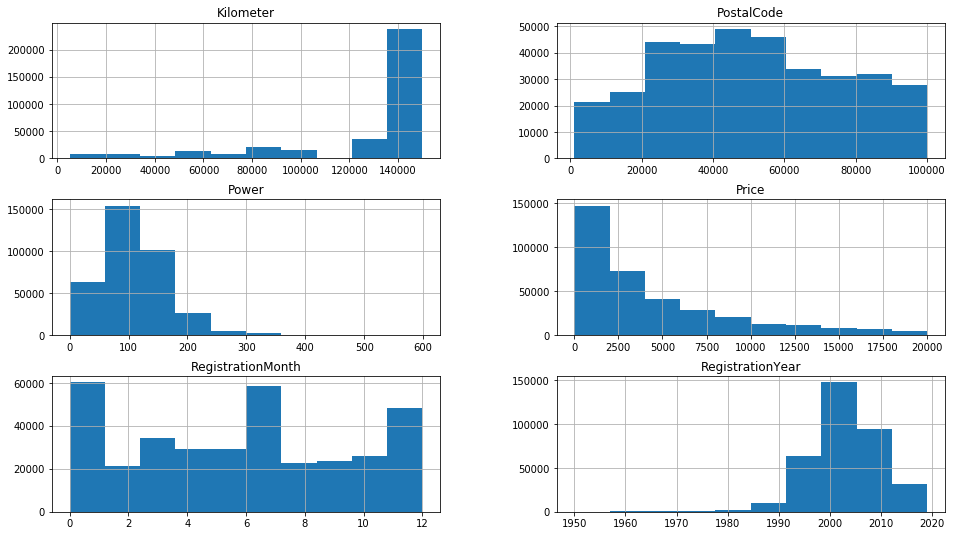

In [33]:
data.hist(figsize = (16,9))
plt.show()

Распределения значений в обработанных признаках выглядят адекватно.

Удалим из датасета признаки, с минимальной вероятностью влияющие на цену автомобилей - ***DateCrawled***, ***DateCreated***, ***LastSeen***:

In [34]:
for feature in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data = data.drop(feature, axis = 1)

Проверим удаление:

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353634 entries, 0 to 354368
Data columns (total 12 columns):
Price                353634 non-null int64
VehicleType          353634 non-null object
RegistrationYear     353634 non-null int64
Gearbox              353634 non-null object
Power                353634 non-null int64
Model                353634 non-null object
Kilometer            353634 non-null int64
RegistrationMonth    353634 non-null int64
FuelType             353634 non-null object
Brand                353634 non-null object
NotRepaired          353634 non-null object
PostalCode           353634 non-null int64
dtypes: int64(6), object(6)
memory usage: 35.1+ MB


Признаки успешно удалены.

###### Вывод

На данном этапе выполнена предобработка данных:

 - В столбцах ***Model*** и ***FuelType*** устранены скрытые дубликаты путем объединения повторяющихся, но записанных по-разному категорий;
 - Из датасета удалены грубые дубликаты;
 - Из столбца ***RegistrationYear*** удалены аномалии. Сохраненный диапазон значений для дальнейшей работы - от 1950 до 2021;
 - Из столбца ***Power*** удалены аномалии. Сохраненный диапазон значений для дальнейшей работы - от 0 до 600;
 - Из датасета удален столбец ***NumberOfPictures***, содержащий только нулевые значения;
 - Из датасета удалены столбцы ***DateCrawled***, ***DateCreated***, ***LastSeen*** в связи с их маловероятным влиянием на цену автомобилей.

### Подготовка признаков

В датасете призаки ***VehicleType***, ***GearBox***, ***Model***, ***FuelType***, ***Brand***, ***NotRepaired*** - категориальные. Из них признаки ***GearBox*** и ***NotRepaired*** содержат по три категории, а остальные от 6 до до нескольких десятков. При кодировании признаков, содержащих множество категорий, методом прямого кодирования, мы рискуем сильно расширить признаковое пространство, и получить множество незначащих признаков. В связи с этим, применим метод порядкового кодирования категориальных признаков:

In [36]:
objects = [
    'VehicleType',
    'Gearbox',
    'Model',
    'FuelType',
    'Brand',
    'NotRepaired']

encoder = OrdinalEncoder()

data[objects] = pd.DataFrame(encoder.fit_transform(data[objects]),columns=data[objects].columns, index = data.index)

Проверим кодировку:

In [37]:
data.describe()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
count,353634.000000,353634.000000,353634.000000,353634.000000,353634.000000,353634.000000,353634.000000,353634.000000,353634.000000,353634.000000,353634.000000,353634.000000
mean,4419.070316,4.748206,2003.127120,0.868174,106.542524,115.479001,128309.579961,5.718805,4.933276,20.898647,0.403502,50518.908176
std,4513.774829,2.387154,7.302403,0.474530,63.359412,73.624278,37760.918439,3.724597,1.883242,13.300754,0.666428,25783.003571
min,0.000000,0.000000,1950.000000,0.000000,0.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,1067.000000
25%,1076.250000,4.000000,1999.000000,1.000000,69.000000,42.000000,125000.000000,3.000000,2.000000,9.000000,0.000000,30165.000000
50%,2700.000000,5.000000,2003.000000,1.000000,105.000000,116.000000,150000.000000,6.000000,6.000000,24.000000,0.000000,49419.000000
75%,6400.000000,7.000000,2008.000000,1.000000,141.000000,170.000000,150000.000000,9.000000,6.000000,33.000000,1.000000,71088.000000
max,20000.000000,8.000000,2019.000000,2.000000,599.000000,249.000000,150000.000000,12.000000,7.000000,39.000000,2.000000,99998.000000


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353634 entries, 0 to 354368
Data columns (total 12 columns):
Price                353634 non-null int64
VehicleType          353634 non-null float64
RegistrationYear     353634 non-null int64
Gearbox              353634 non-null float64
Power                353634 non-null int64
Model                353634 non-null float64
Kilometer            353634 non-null int64
RegistrationMonth    353634 non-null int64
FuelType             353634 non-null float64
Brand                353634 non-null float64
NotRepaired          353634 non-null float64
PostalCode           353634 non-null int64
dtypes: float64(6), int64(6)
memory usage: 35.1 MB


Категориальные значения закодированы успешно.

Отделим признаки от целевого:

In [39]:
features = data.drop(['Price'], axis = 1)
target = data['Price']

Разделим данные на выборки в следующем соотношении:

 - Обучающая выборка: 75%;
 - Тестовая выборка: 25%.

In [40]:
features_train,features_test,target_train,target_test = train_test_split(
    features,
    target,
    test_size = 0.25,
    random_state = 12345)

Проверим разделение:

In [41]:
print('Размер обучающей таблицы признаков:',features_train.shape)
print('Размер обучающей таблицы с целевым признаком:',target_train.shape)
print('Размер тестовой таблицы признаков:',features_test.shape)
print('Размер тестовой таблицы с целевым признаком:',target_test.shape)

Размер обучающей таблицы признаков: (265225, 11)
Размер обучающей таблицы с целевым признаком: (265225,)
Размер тестовой таблицы признаков: (88409, 11)
Размер тестовой таблицы с целевым признаком: (88409,)


Данные разделены успешно в необходимых пропорциях.

При разном масштабе признаков алгоритмы обучения могут сильнее выделять те или иные признаки. Для того, чтобы алгоритм воспринимал значимость каждого из признаков одинаково, стандартизируем признаки:

In [42]:
scaler = StandardScaler()
scaler.fit(features_train)

pd.options.mode.chained_assignment = None

features_train = pd.DataFrame(scaler.transform(features_train), columns = features.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = features.columns)

Проверим результат:

In [43]:
display(features_train.describe())
display(features_test.describe())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
count,2.652250e+05,2.652250e+05,2.652250e+05,2.652250e+05,2.652250e+05,2.652250e+05,2.652250e+05,2.652250e+05,2.652250e+05,2.652250e+05,2.652250e+05
mean,6.568954e-17,3.808064e-15,1.433275e-17,-2.132499e-17,-5.151083e-17,-1.856158e-16,-4.114973e-17,1.394161e-16,1.089825e-16,7.631185e-17,-1.353641e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.993250e+00,-7.251382e+00,-1.830457e+00,-1.681161e+00,-1.570759e+00,-3.255323e+00,-1.532540e+00,-2.621850e+00,-1.573076e+00,-6.066361e-01,-1.917145e+00
25%,-3.148213e-01,-5.627218e-01,2.766374e-01,-5.911592e-01,-1.000113e+00,-8.517475e-02,-7.279690e-01,-1.559585e+00,-8.965630e-01,-6.066361e-01,-7.894191e-01
50%,1.047859e-01,-1.670875e-02,2.766374e-01,-2.246274e-02,5.311421e-03,5.752727e-01,7.660198e-02,5.649462e-01,2.309590e-01,-6.066361e-01,-4.344121e-02
75%,9.440004e-01,6.658076e-01,2.766374e-01,5.462337e-01,7.389993e-01,5.752727e-01,8.811730e-01,5.649462e-01,9.826403e-01,8.925166e-01,7.976830e-01
max,1.363608e+00,2.167344e+00,2.383732e+00,7.781316e+00,1.812358e+00,5.752727e-01,1.685744e+00,1.096079e+00,1.358481e+00,2.391669e+00,1.917037e+00


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
count,88409.000000,88409.000000,88409.000000,88409.000000,88409.000000,88409.000000,88409.000000,88409.000000,88409.000000,88409.000000,88409.000000
mean,-0.003475,0.002574,-0.004526,0.007619,-0.007069,0.009030,0.004753,-0.006504,-0.008656,-0.006900,-0.002322
std,1.006647,0.987143,0.999509,1.003559,1.001258,0.990190,0.995588,1.000991,0.999143,0.996284,0.996992
min,-1.993250,-7.251382,-1.830457,-1.681161,-1.570759,-3.255323,-1.532540,-2.621850,-1.573076,-0.606636,-1.917145
25%,-0.314821,-0.562722,0.276637,-0.591159,-1.000113,-0.085175,-0.727969,-1.559585,-0.896563,-0.606636,-0.789419
50%,0.104786,-0.016709,0.276637,-0.022463,0.005311,0.575273,0.076602,0.564946,0.230959,-0.606636,-0.043015
75%,0.944000,0.665808,0.276637,0.577828,0.738999,0.575273,0.881173,0.564946,0.907472,0.892517,0.795629
max,1.363608,2.167344,2.383732,7.560157,1.812358,0.575273,1.685744,1.096079,1.358481,2.391669,1.917037


Данные успешно стандартизированы.

Построим матрицу корреляций для определения мкльтиколлинеарных признаков:

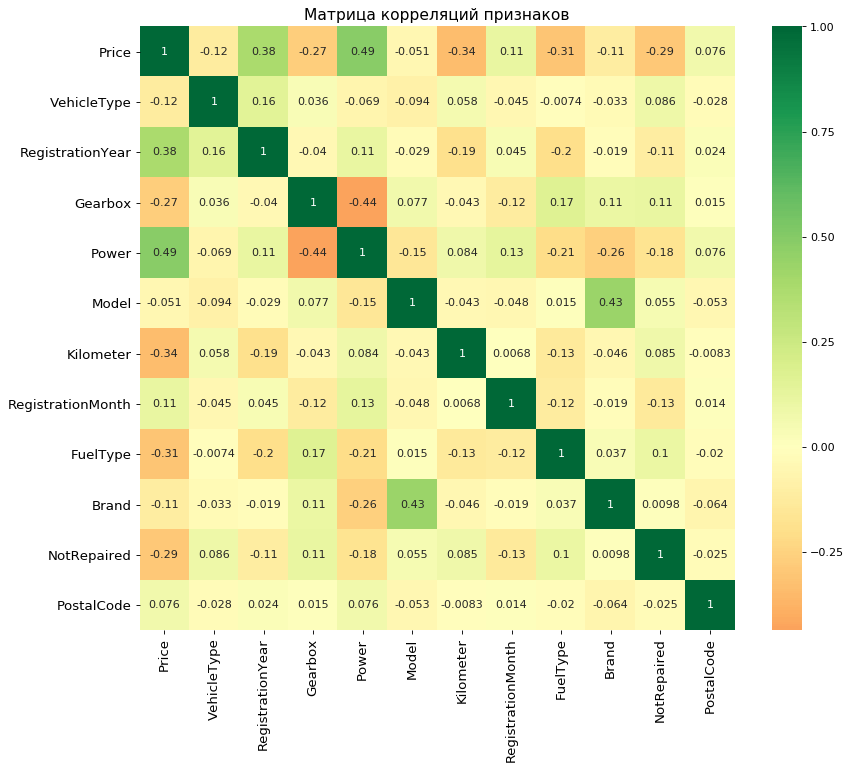

In [44]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(
    data.corr(),
    xticklabels=data.corr().columns,
    yticklabels=data.corr().columns,
    cmap='RdYlGn',
    center=0,
    annot=True
)

plt.title('Матрица корреляций признаков', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

###### Вывод

На данном этапе категориальные признаки ***VehicleType***, ***GearBox***, ***Model***, ***FuelType***, ***Brand***, ***NotRepaired*** были перекодированы в числовые с помощью метода порядкового кодирования во избежание расширения признакового пространства и получения множества незначащих признаков.

Целевые признаки были отделены от остальных, а данные разбиты на обучающую и тестовую выборки в соотношении 75% : 25%.

Признаки обучающей и тестовой выборок были стандартизированы с помощью ***StandardScaler*** во избежание неравного восприятия моделями значимсоти признаков.

С помощью матрицы корреляции было определено, что наиболее заметные корреляции наблюдаются между ***Price*** и следующими признаками:  ***RegistrationYear***, ***Power***, ***Kilometer***. Вероятнее всего, именно эти признаки в конечном итоге окажутся наиболее важными для построения качественной модели. Также умеренная связь присутствует между ***Brand*** и ***Model***, но значение коэффициента недостаточно для того, что исключить данный признак их конечного датасета. В итоге, все признаки будут использованы для построения модели.

## Подбор моделей

Целевой метрикой в данной задаче является квадрат средней квадратичной ошибки ( ***Root Mean Squared Error, RMSE*** ). Подберем модель, позволяющую добиться минимального значения метрики с помощью ***GridSearchCV***.

Напишем функцию для подбора наилучших параметров модели:

In [45]:
def get_best_params(model,parameters):
    grid = GridSearchCV(
    model,
    parameters,    
    scoring = 'neg_root_mean_squared_error'
    )
    
    grid.fit(features_train,target_train)
    
    greed_result = pd.DataFrame(
        grid.cv_results_).sort_values(
        by = 'rank_test_score').reset_index(
        drop = True)
    
    display(greed_result[greed_result['rank_test_score']==1])

Рассмотрим модель ***Дерево решений***:

In [46]:
decision_tree = DecisionTreeRegressor()

In [47]:
get_best_params(
    decision_tree,
    {
        'max_depth':range(11,21,1),
        'random_state':[12345]
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.576976,0.00867,0.006188,0.000065,13,12345,"{'max_depth': 13, 'random_state': 12345}",-2085.701772,-2086.667495,-2091.835584,-2115.692421,-2082.734225,-2092.526299,11.949316,1


Наилучшее значение метрики, ***RMSE = 2093***, получено при максимальной глубине дерева = ***13***.

Рассмотрим модель ***Случайный лес***:

In [47]:
random_forest = RandomForestRegressor()

In [49]:
get_best_params(
    random_forest,
    {
        'max_depth':[11],
        'n_estimators': range(1,61,10),       
        'random_state':[12345]
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.357399,0.034083,0.18844,0.000941,11,51,12345,"{'max_depth': 11, 'n_estimators': 51, 'random_...",-1955.413969,-1932.304564,-1967.003744,-1981.700743,-1953.214121,-1957.927428,16.325526,1


Наилучшее значение метрики, ***RMSE = 1958***, получено при максимальной глубине дерева = ***11*** и количестве деревьев = ***51***.

Рассмотрим модель ***Линейная регрессия***:

In [48]:
linear_regression = LinearRegression()

In [51]:
get_best_params(linear_regression, {'n_jobs': [None]})

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.214777,0.008109,0.001615,0.000471,None,{'n_jobs': None},-3122.546827,-3123.289742,-3153.42244,-3146.608543,-3123.36989,-3133.847488,13.378896,1


В результате применения линейной регрессии полученное значение ***RMSE = 3134***.

Далее попробуем применить градиентный бустинг.
Рассмотрим модель ***XGBRegressor***:

In [49]:
xgbr = xgb.XGBRegressor()

In [54]:
warnings.simplefilter(action='ignore', category=UserWarning)

get_best_params(
    xgbr,
    {
     'booster': ['gbtree'],
     'objective': ['reg:squarederror'],
     'seed':[12345],
     'max_depth': range(11,21,1)
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_max_depth,param_objective,param_seed,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.397414,0.271942,0.04853,0.005566,gbtree,11,reg:squarederror,12345,"{'booster': 'gbtree', 'max_depth': 11, 'object...",-1724.894655,-1711.495061,-1730.604922,-1756.701574,-1719.536385,-1728.64652,15.376378,1


Наилучшее значение метрики, ***RMSE = 1729***, получено при максимальной глубине деревьев = ***11***. Перебор других гиперпараметров не оказал существенного вляиния на значение метрики.

Рассмотрим модель ***LGBMRegressor***

In [50]:
lgbr = lgb.LGBMRegressor()

In [56]:
get_best_params(
    lgbr,
    {
        'learning_rate':[0.23],
        'max_depth':[-1],
        'num_leaves':[752],
        'n_estimators':range(100,500,50)
    }
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.185904,0.194251,0.157483,0.00197,0.23,-1,100,752,"{'learning_rate': 0.23, 'max_depth': -1, 'n_es...",-1714.511843,-1690.433435,-1724.060061,-1729.577954,-1720.091823,-1715.735023,13.576312,1


Наилучшее значение метрики, ***RMSE = 1716*** получено при следующих гиперпараметрах:
 - ***learning_rate*** = ***0.23***;
 - ***max_depth*** = ***не ограничено***;
 - ***num_leaves*** = ***752***;
 - ***n_estimators*** = ***100***.

Рассмотрим модель ***CatBoostRegressor***:

In [51]:
cbr = cb.CatBoostRegressor()

In [58]:
get_best_params(
    cbr,
    {'silent':[True],
     'iterations':[901],
     'learning_rate':[0.38]           
    }
)    

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,param_learning_rate,param_silent,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.395184,0.091399,0.011926,0.000961,901,0.38,True,"{'iterations': 901, 'learning_rate': 0.38, 'si...",-1727.890355,-1705.478007,-1723.260552,-1748.861801,-1729.070611,-1726.912265,13.857559,1


Наилучшее значение метрики, ***RMSE = 1727*** получено при следующих гиперпараметрах:
 - ***iterations*** = ***901***;
 - ***learning_rate*** = ***0.38***.

###### Вывод

На данном этапе были рассмотрены следующие модели, потенциально позволяющие решить поставленную проектом задачу:

 - ***Дерево решений***;
 - ***Случайный лес***;
 - ***Линейная регрессия***;
 - ***XGBoost Regressor***;
 - ***LightGBM Regressor***;
 - ***CatBoost Regressor***.
 
 К каждой модели были подобраны гиперпараметры с помощью ***GridsearchCV*** для получения наилучшего значения ***RMSE***.
 
 В результате выделен ТОП-3 моделей с лучшим значением ***RMSE***:
 
  1. ***LightGBM Regressor*** ( RMSE = 1716 );
  2. ***CatBoost Regressor*** ( RMSE = 1727 );
  3. ***XGBoost Regressor*** ( RMSE = 1729 ).
  
  Из моделей, не использующих бустинг, лучшее ***RMSE*** оказалось у ***Случайного леса*** ( RMSE = 1958 ).
  
 Далее исследуем время обучения и предсказания цен на автомобили, а также ***RMSE*** на тестовой выборке каждой модели из ТОП-3 и ***Случайного леса***.

## Анализ моделей

### LightGBM Regressor

Обучим модель ***LightGBM Regressor*** с заданием подобранных на предыдущем этапе гиперпараметров и рассчитаем время обучения:

In [49]:
%%time

lgbr = lgb.LGBMRegressor(
    learning_rate = 0.23,
    max_depth = -1,
    num_leaves = 752,
    n_estimators = 100
)

lgbr.fit(features_train, target_train)

CPU times: user 31.4 s, sys: 353 ms, total: 31.7 s
Wall time: 32.2 s


LGBMRegressor(learning_rate=0.23, num_leaves=752)

Время обучения ***LightGBM Regressor*** = 31.7 секунд.

Рассчитаем время предсказания моделью целевого признака:

In [50]:
%%time
lgbr_predictions = lgbr.predict(features_test)

CPU times: user 1.44 s, sys: 9.28 ms, total: 1.45 s
Wall time: 1.36 s


Время предсказаний ***LightGBM Regressor*** = 1.45 секунд.

Рассчитаем ***RMSE*** модели на тестовой выборке:

In [61]:
rmse_lgbr = mean_squared_error(target_test, lgbr_predictions)**0.5
print('RMSE модели на тестовой выборке: ', rmse_lgbr.round(0))

RMSE модели на тестовой выборке:  1672.0


### CatBoost Regressor

Обучим модель ***CatBoost Regressor*** с заданием подобранных на предыдущем этапе гиперпараметров и рассчитаем время обучения:

In [62]:
%%time

cbr = cb.CatBoostRegressor(
    silent = True,
    iterations = 901,
    learning_rate = 0.38,
)

cbr.fit(features_train, target_train)

CPU times: user 43.5 s, sys: 4.51 s, total: 48 s
Wall time: 9.66 s


Время обучения ***CatBoost Regressor*** = 48 секунд.

Рассчитаем время предсказания моделью целевого признака:

In [63]:
%%time
cbr_predictions = cbr.predict(features_test)

CPU times: user 131 ms, sys: 4.14 ms, total: 135 ms
Wall time: 37.5 ms


Время предсказания ***CatBoost Regressor*** = 135 милисекунд.

Рассчитаем ***RMSE*** модели на тестовой выборке:

In [68]:
rmse_сbr = mean_squared_error(target_test, cbr_predictions)**0.5
print('RMSE модели на тестовой выборке: ', rmse_сbr.round(0))

RMSE модели на тестовой выборке:  1702.0


### XGBoost Regressor

Обучим модель ***XGBoost Regressor*** с заданием подобранных на предыдущем этапе гиперпараметров и рассчитаем время обучения:

In [69]:
%%time

xgbr = xgb.XGBRegressor(
    booster = 'gbtree',
    objective = 'reg:squarederror',
    seed = 12345,
    max_depth = 11
)

xgbr.fit(features_train, target_train)

CPU times: user 1min 48s, sys: 7.4 s, total: 1min 55s
Wall time: 15.4 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=11,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=12345, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Время обучения ***XGBoost Regressor*** = 1 минута 55 секунд.

Рассчитаем время предсказания моделью целевого признака:

In [70]:
%%time
xgbr_predictions = xgbr.predict(pd.DataFrame(features_test))

CPU times: user 659 ms, sys: 18.8 ms, total: 678 ms
Wall time: 115 ms


Время предсказания ***XGBoost Regressor*** = 678 милисекунда.

Рассчитаем ***RMSE*** модели на тестовой выборке:

In [71]:
rmse_xgbr = mean_squared_error(target_test, xgbr_predictions)**0.5
print('RMSE модели на тестовой выборке: ', rmse_xgbr.round(0))

RMSE модели на тестовой выборке:  1683.0


### Случайный лес

Обучим модель ***Случайный лес*** с заданием подобранных на предыдущем этапе гиперпараметров и рассчитаем время обучения:

In [46]:
%%time

random_forest = RandomForestRegressor(
    max_depth = 11,
    n_estimators = 51
)

random_forest.fit(features_train, target_train)

CPU times: user 30.2 s, sys: 0 ns, total: 30.2 s
Wall time: 30.5 s


RandomForestRegressor(max_depth=11, n_estimators=51)

Время обучения ***Случайный лес*** = 30.2 секунды.

Рассчитаем время предсказания моделью целевого признака:

In [47]:
%%time
random_forest_predictions = random_forest.predict(pd.DataFrame(features_test))

CPU times: user 439 ms, sys: 0 ns, total: 439 ms
Wall time: 437 ms


Время предсказания ***Случайный лес*** = 439 милисекунд.

Рассчитаем ***RMSE*** модели на тестовой выборке:

In [48]:
rmse_random_forest = mean_squared_error(target_test, random_forest_predictions)**0.5
print('RMSE модели на тестовой выборке: ', rmse_random_forest.round(0))

RMSE модели на тестовой выборке:  1933.0


###### Вывод

Сформируем итоговую таблицу:

In [52]:
results = pd.DataFrame(
    {
        'Модель':['LightGBM Regressor', 'CatBoost Regressor', 'XGBoost Regressor', 'Случайный лес'],
        'RMSE':[1672, 1702, 1683, 1933],
        'Время обучения, сек': [31.7, 48, 115, 30.2],
        'Время предсказаний, сек': [1.45, 0.135, 0.678, 439]
    },
    index = [1,2,3,4]
)

results.RMSE = results.RMSE.astype(int)

results.sort_values(by = 'RMSE')

,Модель,RMSE,"Время обучения, сек","Время предсказаний, сек"
1,LightGBM Regressor,1672,31.7,1.450
3,XGBoost Regressor,1683,115.0,0.678
2,CatBoost Regressor,1702,48.0,0.135
4,Случайный лес,1933,30.2,439.000


Наиболее качественной моделью остается ***LightGBM Regressor***. Наименее качественной оказалась модель, построенная с помощью ***Случайного леса***.

С точки зрения времени обучения, важного заказчику, лидирующую позицию занимает ***Случайный лес***. 
Наибольшее время обучения у ***XGBoost Regressor***.

Так как у ***Случайного леса*** наименьшее качество, рекомендуемая для потребностей заказчика модель - ***LightGBM Regressor***, лидирующая по качеству и показывающая время обучения, наиболее близкое к ***Случайному лесу***.

Значимость признаков для ***LightGBM Regressor*** приведена ниже:

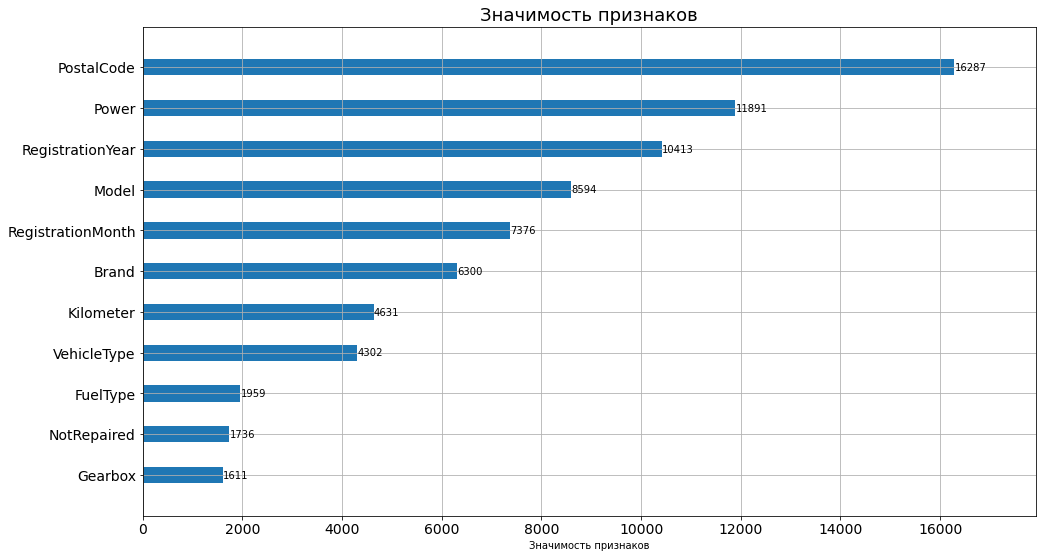

In [73]:
lgb.plot_importance(
    lgbr,
    height=0.4,
    title='Значимость признаков',
    xlabel='Значимость признаков',
    max_num_features=None,
    ignore_zero=True,
    figsize=(16,9),
    dpi=None,
    grid=True,
    precision=3
)
plt.title('Значимость признаков',fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('',fontsize=14)
plt.show()

## Общий вывод

В ходе данного проекта данные о выставленных на продажу автомобилях были изучены, предобработаны и разделены на две выборки: обучающую и тестовую в соотношении ***75% : 25%***.

Выборки были использованы для подбора, обучения и тестирования моделей: ***Дерево решений***, ***Случайный лес***, ***Логистическая ререссия***, ***XGBoost Regressor***, ***LightGBM Regressor***, ***CatBoost Regressor***.

В соответствии с условиями задачи целевой метрикой качества моделей было выбрано ***RMSE***.

Для подбора гиперпараметров, а также предварительной оценки качества моделей методом кросс-валидации был применен ***GridSearchCV***.

В результате подбора моделей были выбраны четыре наиболее перспективных:

  1. ***LightGBM Regressor***;
  2. ***CatBoost Regressor***;
  3. ***XGBoost Regressor***;
  4. ***Случайный лес***,
  
которые были протестированы на скорость обучения и качество предсказаний на тестовой выборке.

Наилучшей с точки зрения требований заказчика оказалась модель ***LightGBM Regressor***, с ***RMSE*** на тестовой выборке = ***1672*** и с ***31.7 секундами***, затраченными на обучение.

Модель предсказывает цену на подержаные автомобили со среднеквадратичной разницей между расчетными и фактическими значениями в ***1672*** евро. Ошибка достаточно высока, и ее значение связано с множеством некорректных данных в исходном датасете, изменения которых не было возможности согласовать с заказчиком, в результаты чего данные были предобработаны с минимальными потерями.

С помощью ***LightGBM Regressor*** определены значимость признаков для предсказания моделью целевого признака. Ниже отражен ТОП-5 в порядке убывания значимости:

1. Регион продажи, определяемый почтовым кодом;
2. Мощность двигателя;
3. Год регистрации автомобиля;
4. Модель автомобиля;
5. Месяц регистрации автомобиля.

ТОП выглядит правдоподобным: в разных странах разные цены на подержаные автомобили, что часто используется перегонщиками автомобилей для последующей перепродажи. Мощность, возраст и модель автомобиля в жизни также играют важную роль при формировании цены. Попадание в ТОП-5 признаков месяца регистрации автомобилей можно связать с годом регистрации, что в совокупности определяют его возраст, но при этом, год регистрации является определяющим возраст признаком.

Подробнее со значимсотью признаков можно ознакомиться в предыдущем разделе.